<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:35%"><img src='https://dl.dropboxusercontent.com/s/hrpgwq7gqoxf4am/smu_scis.png' style="width: 300px; height: 60px; "></th>
    <th style="text-align:center;"><font size="4"> <br/>Analytics in Python</font></th>
    </tr>
</table> 

The following program is to illustrate the steps to create an analytics model (or more specifically, a classification model) with the reduced Bank Marketing dataset (reduced the 'no' dataset to 7000 and features from 20 to 7) from the UCI Machine Learning Repository - https://archive.ics.uci.edu/ml/datasets/Bank+Marketing. 

This dataset represents the <b>direct marketing campaigns of a Portuguese bank</b> and <b>whether the efforts led to a bank term deposit</b>.
<br />The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are <b>7 input variables</b> and <b>1 target variable</b> - predict if the client will subscribe (yes/no) a term deposit (variable y).
The variable names and their brief description are as follows:
- <b>age</b> (numeric)
- <b>education</b> (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- <b>default</b>: has credit in default? (categorical: 'no','yes','unknown')
- <b>housing</b>: has housing loan? (categorical: 'no','yes','unknown')
- <b>loan</b>: has personal loan? (categorical: 'no','yes','unknown')
- <b>campaign</b>: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- <b>emp.var.rate</b>: employment variation rate - quarterly indicator (numeric)
- <b>y</b>: has the client subscribed a term deposit? (binary: <b>'yes'</b>,<b>'no'</b>)

### Step 1: import relevant libraries

In [1]:
# import the necessary libraries
# ------------------------------
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import GridSearchCV

### Step 2: read in the data

In [2]:
# read in data file
# -----------------
df = pd.read_csv('uci_bank_dbtt.csv')

# check top 5 rows from data file
df.head()

,age,education,default,housing,loan,campaign,emp.var.rate,y
0,48,basic.9y,no,yes,no,2,-1.8,no
1,31,basic.9y,no,yes,no,1,1.4,no
2,52,professional.course,no,yes,yes,1,-0.1,no
3,48,university.degree,unknown,yes,no,2,1.4,no
4,22,high.school,no,yes,no,2,1.4,no


In [3]:
# summary statistics
# ------------------
df.describe(include='all')

,age,education,default,housing,loan,campaign,emp.var.rate,y
count,11640.000000,11640,11640,11640,11640,11640.000000,11640.000000,11640
unique,NaN,8,3,3,3,NaN,NaN,2
top,NaN,university.degree,no,yes,no,NaN,NaN,no
freq,NaN,3669,9569,6202,9594,NaN,NaN,7000
mean,40.319244,NaN,NaN,NaN,NaN,2.402749,-0.349880,NaN
std,11.616475,NaN,NaN,NaN,NaN,2.485596,1.702676,NaN
min,17.000000,NaN,NaN,NaN,NaN,1.000000,-3.400000,NaN
25%,32.000000,NaN,NaN,NaN,NaN,1.000000,-1.800000,NaN
50%,38.000000,NaN,NaN,NaN,NaN,2.000000,-0.100000,NaN
75%,48.000000,NaN,NaN,NaN,NaN,3.000000,1.400000,NaN


### Step 3: Separate the attributes and target (in the initial dataset)

Since the data is read as a whole into the dataframe `df`, there is a need to <b>separate</b> `df` into 2 parts: 
- <b>input variables</b> or information regarding the predictive values and 
- the <b>target</b> value. The target value is actually the label of the input values, indicating if the person has subscribed to the term deposit or not.

`X = df.drop('y', axis=1)` is to create `X` with only the first 7 columns of client information and removing the last column (`'y'`). In deed, it doesn't make sense to include 'y' in the data to train the model since it is the target we want to learn and predict.

`y = df['y']` is creating a dataframe that only contains the target value - 'yes' or 'no' 

In [4]:
# Separate input (X) and target (y) dataframes
# --------------------------------------------

X = df.drop('y', axis=1)
y = df['y']

#(,) --> means 1 col
print(X.shape,y.shape)

(11640, 7) (11640,)


In [5]:
# distribution of class
# quite balanced dataset

print(y.value_counts())

no     7000
yes    4640
Name: y, dtype: int64


In [6]:
X.head()

,age,education,default,housing,loan,campaign,emp.var.rate
0,48,basic.9y,no,yes,no,2,-1.8
1,31,basic.9y,no,yes,no,1,1.4
2,52,professional.course,no,yes,yes,1,-0.1
3,48,university.degree,unknown,yes,no,2,1.4
4,22,high.school,no,yes,no,2,1.4


In [7]:
y.head()

0    no
1    no
2    no
3    no
4    no
Name: y, dtype: object

### Step 4: preprocess data

There is a need to ensure the data is processed as follows:
- For the columns which contain <u>numeric variables</u>:
Since the range of input values are of different scales (from `df.describe()`), we can choose to perform data standardisation using either standardisation or normalisation. Assuming that the distribution will not always be normal,  <b>normalising</b> the values between `0-1` will be a better choice so that the range of values won't influence the model. <br />It is important to do the <b>same scaling</b> on both input values of training data (`X_train`) and testing data (`X_test`) to ensure meaningful evaluation.
- For the columns which contain <u>categorical variables</u>:
It is necessary to convert them to <b>one-hot encoding</b>. One-hot encoding converts each categorical value into a new column and assign a 1 or 0 (True/False) value to the column. It has the benefit of not weighting a value improperly.

In [8]:
def preprocess_data(X):
    # for numerical columns
    # ---------------------
    # we normalize using MinMaxScaler to constrain values between 0 and 1
    
    scaler = MinMaxScaler(feature_range = (0,1))
    df_numeric = X.select_dtypes(include=[np.number]) # find columns corresponds to numbers
    numeric_cols = df_numeric.columns.values          # take those 2 columns as values

    print(numeric_cols)
    
    for col in numeric_cols:
        # fit_transform() of scaler can be applied to each column individually
        X[col] = scaler.fit_transform(X[[col]]) # apply normalisation
        
    print("---Successfully processed numeric column(s)")
    print(X.head(5))
    
    
    # for categorical columns
    # -----------------------
    # we convert the column into one-hot encoding
    df_categorical = X.select_dtypes(exclude=[np.number]) # find out columns that are categorical
    categorical_cols = df_categorical.columns.values      # get their values
    
    # the function get_dummies() (from pandas) creates one-hot encoding
    X = pd.get_dummies(X,columns=categorical_cols) # doing one-hot
           
    print("---Successfully processed categorical column(s)")
    print(X.head(5))
        
    return X

In [9]:
# execute preprocess_data()
# this is the preprocesssed metrics to fit into algorithm

X = preprocess_data(X)

['age' 'campaign' 'emp.var.rate']
---Successfully processed numeric column(s)
        age            education  default housing loan  campaign  emp.var.rate
0  0.382716             basic.9y       no     yes   no   0.02381      0.333333
1  0.172840             basic.9y       no     yes   no   0.00000      1.000000
2  0.432099  professional.course       no     yes  yes   0.00000      0.687500
3  0.382716    university.degree  unknown     yes   no   0.02381      1.000000
4  0.061728          high.school       no     yes   no   0.02381      1.000000
---Successfully processed categorical column(s)
        age  campaign  emp.var.rate  education_basic.4y  education_basic.6y  \
0  0.382716   0.02381      0.333333                   0                   0   
1  0.172840   0.00000      1.000000                   0                   0   
2  0.432099   0.00000      0.687500                   0                   0   
3  0.382716   0.02381      1.000000                   0                   0   
4  0.

### Step 5: split data into training and testing data

In order to train a classifier or a classification model, there is a need to <b>split</b> the <b>processed input data</b> and the corresponding <b>target</b>. We then get two parts: <b>training data</b> and <b>testing data</b>. 

We will then use the <u>training data</u> to <u>create a model</u> use the <u>testing data</u> to <u>evaluate the model</u>.

`Scikit-learn` provides a useful function - `train_test_split()` that is able to separate two set of data according to a proportion, for example, when test_size=0.3, it means splitting 70% training - 30% testing. 

It is common to use `X` to denote input values and `y` to indicate target value in scikit-learn. As a result, `X_train`, `y_train` is essentially the input values and corresponding target value of training data. Similarly for `X_test` and `y_test` for testing data.

In [10]:
# Split feature and label sets to train and data sets - 80-20
# random_state is desirable for reproducibility
# stratify - to keep the same proportion of (yes and no) as input dataset

# 20% test data, random state will choose rows - not on top and down then choose to split already for equality
# stratify: when we split yes-no we will have same version of yes at a certain position
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10, stratify = y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9312, 20) (2328, 20) (9312,) (2328,)


### Step 6: create the Logistic Regression model

The algorithm used in this example is <b>Logistic Regression</b>. It is one of the commonly used classification algorithm. The model created is `logreg`. You can use any other variable to represent it, e.g., 'lr'. 

`logreg.fit(X_train, y_train)` : uses the training input data and target value to build the `logreg` model. After this command, `logreg` will learn the 'rules'/'knowledge' of whether a customer is likely to open a deposit account or not.

`y_pred = logreg.predict(X_test)` : the `logreg` model is used to predict `X_test` and the predicted result is assigned to `y_pred`. If the model has learnt all the 'knowledge/rules', `y_pred` will be 100% match with `y_test`. 

The subsequent codes are to evaluate the predicted results using both accuracy and F1-score. 

Testing accuracy 0.7173539518900344
              precision    recall  f1-score   support

          no       0.77      0.76      0.76      1400
         yes       0.65      0.65      0.65       928

    accuracy                           0.72      2328
   macro avg       0.71      0.71      0.71      2328
weighted avg       0.72      0.72      0.72      2328



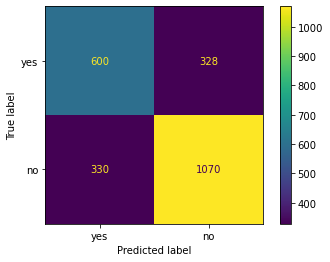

In [11]:
# create a logistic regression classifier
# ---------------------------------------
logreg = LogisticRegression(solver='liblinear', random_state=7)
logreg.fit(X_train, y_train)

# Apply the model on the test data to get a prediction
# ----------------------------------------------------
y_pred = logreg.predict(X_test)

# Get accuracy of the model
# -------------------------
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))

# compute confusion matrix
# ------------------------
labels = ['yes','no']
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels) # purple are the ones you made an error with the model
disp.plot()

# look at the value for both 'yes' and 'no' class, the model can predict 'no' (0.76) better than 'yes' (0.65)
print(classification_report(y_test, y_pred))

In [12]:
# save the model in a file to retrieve it later if necessary
# ----------------------------------------------------------
# filename = 'finalized_model.sav'
# pickle.dump(logreg, open(filename, 'wb'))

### Activity 1 - Feature selection - find the top-3 important features

In [12]:
# Recursive Feature Elimination (or RFE)
# --------------------------------------
# works by recursively removing attributes and  building a model on those attributes that remain.
# top 3 that contribute the most to the model
rfe = RFE(logreg, n_features_to_select=3)
fit = rfe.fit(X, y)

print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 3
Selected Features: [ True  True  True False False False False False False False False False
 False False False False False False False False]
Feature Ranking: [ 1  1  1 16  7  6 15  3 18  5  4  2 17  8 13 12 14  9 10 11]


In [13]:
selected = fit.support_
# get the top-3 feature_names
feature_names = X.columns

# write your code below
# ---------------------
print(feature_names.to_numpy()[selected])

['age' 'campaign' 'emp.var.rate']


### Activity 2 - Based on customer details given in uci_bank_predict.csv, which customer will likely subscribe to a short-term deposit?

In [14]:
# In case you would like to load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))

# a. read in the new data file to predict 
# ---------------------------------------
# hint: (use read_csv of pandas)
df_predict = pd.read_csv('uci_bank_predict.csv')

## b. view data file content
# --------------------------
print(df_predict.shape)
print(df_predict)

(20, 7)
    age            education  default  housing     loan  campaign  \
0    48             basic.6y  unknown      yes       no         2   
1    52  professional.course       no      yes      yes         1   
2    48    university.degree  unknown      yes       no         2   
3    22          high.school       no      yes       no         2   
4    45             basic.9y       no  unknown  unknown         1   
5    50           illiterate       no      yes       no         2   
6    41             basic.6y  unknown      yes      yes         4   
7    39             basic.9y       no       no       no         2   
8    25          high.school  unknown      yes      yes         6   
9    38    university.degree       no       no       no         2   
10   52             basic.4y  unknown      yes       no         3   
11   32    university.degree       no       no  unknown         1   
12   33  professional.course       no  unknown       no         1   
13   31    university.degr

In [15]:
# c. preprocess data before prediction
# ------------------------------------
# hint: remember we created a function for that
# we dont have y column as new data that needs to be predicted
X_predict = preprocess_data(df_predict)

['age' 'campaign' 'emp.var.rate']
---Successfully processed numeric column(s)
        age            education  default  housing     loan  campaign  \
0  0.509804             basic.6y  unknown      yes       no       0.2   
1  0.588235  professional.course       no      yes      yes       0.0   
2  0.509804    university.degree  unknown      yes       no       0.2   
3  0.000000          high.school       no      yes       no       0.2   
4  0.450980             basic.9y       no  unknown  unknown       0.0   

   emp.var.rate  
0      0.113636  
1      0.500000  
2      0.840909  
3      0.840909  
4      0.772727  
---Successfully processed categorical column(s)
        age  campaign  emp.var.rate  education_basic.4y  education_basic.6y  \
0  0.509804       0.2      0.113636                   0                   1   
1  0.588235       0.0      0.500000                   0                   0   
2  0.509804       0.2      0.840909                   0                   0   
3  0.000000

In [16]:
print(X_predict.shape)

(20, 20)


In [17]:
# d. predict using the model
# --------------------------
# hint: use the predict() method of `logreg` model
y_predict = logreg.predict(X_predict)
print(y_predict)

['no' 'yes' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'no' 'yes' 'yes' 'yes'
 'yes' 'no' 'yes' 'yes' 'no' 'yes']


In [18]:
# e. which customer may subscribe to a short-term deposit?
# --------------------------------------------------------
print(np.where(y_predict=='yes'))

(array([ 1, 11, 12, 13, 14, 16, 17, 19], dtype=int64),)


### Activity - Use Grid search and cross validation to find the best parameters of an algorithm. 

Two common problems in machine learning models are overfitting and underfitting. We can often fix either problems by adjusting the hyperparameters on our model. However, there are many hyper-parameters to adjust and the best way to get the best settings is often through trial and error, which can take a lot of work to try all the possible combinations.

A solution to finding suitable values for parameters is to use a Grid Search. Grid search is a method to automate the finding of the optimum values of hyperparameters. It trains and tests the model using every combination of 
parameters. The combination of parameters that generates the best predictions will be the set of parameters that you should use for your real model.

The CV in GridsearchCV stands for cross-validation.The function will automatically slice up the training data into smaller subsets, and use part of the data for training models, and then use a different part of the data for testing those models.

Best cross-validation score: 0.72
Best parameters:  {'C': 10}
Best estimator:  LogisticRegression(C=10, solver='liblinear')
Testing accuracy after grid search 0.7212199312714777
              precision    recall  f1-score   support

          no       0.77      0.77      0.77      1400
         yes       0.65      0.65      0.65       928

    accuracy                           0.72      2328
   macro avg       0.71      0.71      0.71      2328
weighted avg       0.72      0.72      0.72      2328



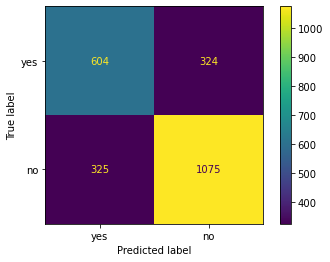

In [19]:
#grid search for parameter
param_grid = {'C': [0.01, 0.1, 1, 10, 20]}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)

grid.fit(X_train, y_train)

print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Best estimator: ", grid.best_estimator_)

#make prediction
lr = grid.best_estimator_
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print('Testing accuracy after grid search %s' % accuracy_score(y_test, y_pred))

#compute confusion matrix
#print(confusion_matrix(y_test, y_pred, labels=labels))
cm=confusion_matrix(y_test, y_pred, labels=['yes','no'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot()

#look at the value for both 'yes' and 'no' class, the model can predict 'no' better than 'yes' 
print(classification_report(y_test, y_pred))

#### As seen from the f1 score, the ability for the Gridsearch to predict "no" of 0.77 is better than logistic regression ability of 0.76.